In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 12.8 MB/s eta 0:00:00


In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import random
import gc
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from IPython.display import Image, clear_output
from torch.cuda import memory_allocated, empty_cache
from torch.optim import Adam
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from glob import glob
from tqdm import tqdm
from google.colab.patches import cv2_imshow

%matplotlib inline

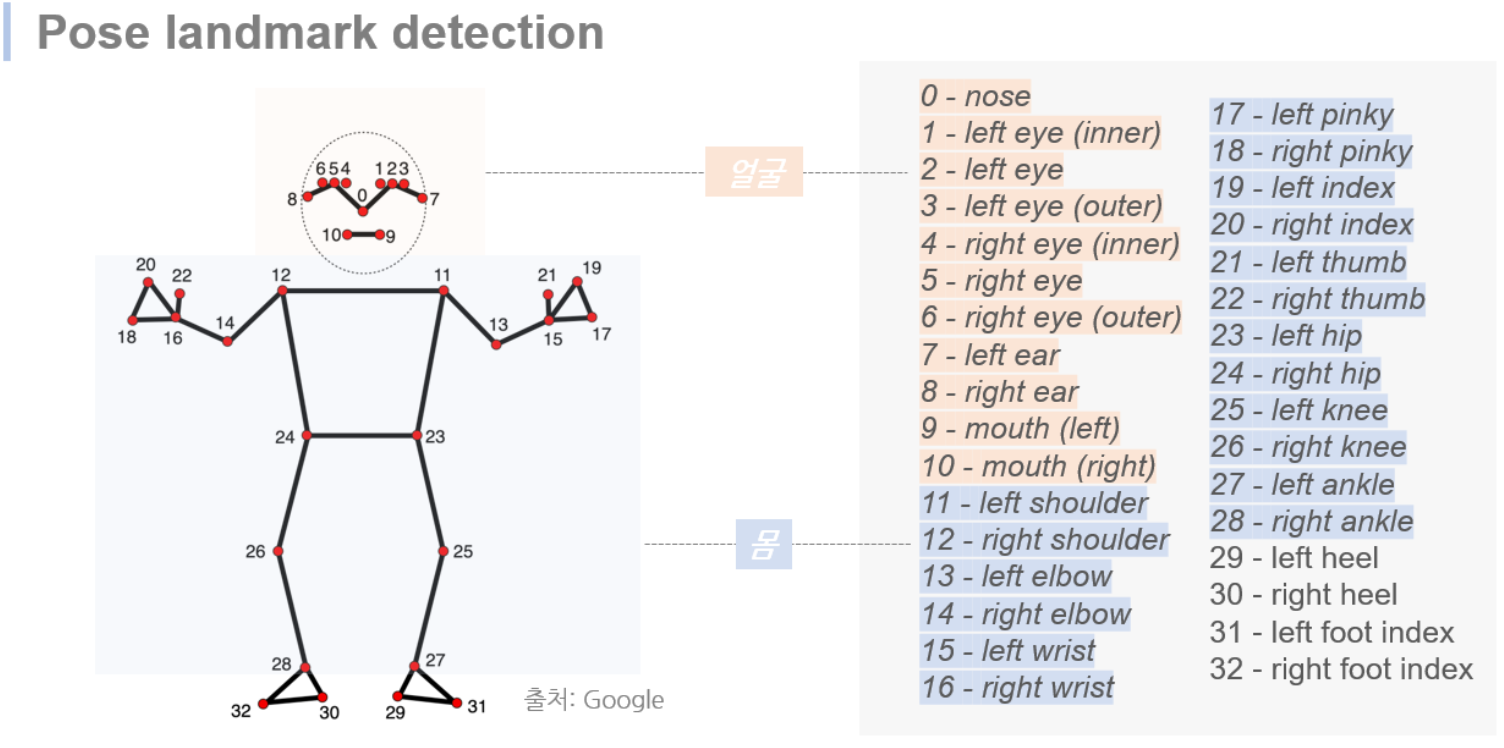



In [ ]:
BATCH_SIZE = 6
EPOCH = 500
NUM_LAYERS = 1      # LSTM model: num_layers
start_dot = 11      # mp.solutions.pose 시작 포인트 (0: 얼굴부터 발목까지, 11: 어깨부터 발목까지)
n_CONFIDENCE = 0.3    # MediaPipe Min Detectin confidence check

mp_pose = mp.solutions.pose
attention_dot = [n for n in range(start_dot, 29)]

# 라인 그리기
if start_dot == 11:
    """몸 부분만"""
    draw_line = [[11, 13], [13, 15], [15, 21], [15, 19], [15, 17], [17, 19], \
                [12, 14], [14, 16], [16, 22], [16, 20], [16, 18], [18, 20], \
                [23, 25], [25, 27], [24, 26], [26, 28], [11, 12], [11, 23], \
                [23, 24], [12, 24]]
    print('Pose : Only Body')

else:
    """얼굴 포함"""
    draw_line = [[11, 13], [13, 15], [15, 21], [15, 19], [15, 17], [17, 19], \
                [12, 14], [14, 16], [16, 22], [16, 20], [16, 18], [18, 20], \
                [23, 25], [25, 27], [24, 26], [26, 28], [11, 12], [11, 23], \
                [23, 24], [12, 24], [9, 10], [0, 5], [0, 2], [5, 8], [2, 7]]
    print('Pose : Face + Body')

Pose : Only Body


In [ ]:
# media pipe landmark 데이터 전처리 함수

def get_skeleton(video_path, attention_dot, draw_line):
    frame_length = 30 # LSTM 모델에 넣을 frame 수
    xy_list_list, xy_list_list_flip = [], []
    cv2.destroyAllWindows()
    pose = mp_pose.Pose(static_image_mode = True, model_complexity = 1, \
                        enable_segmentation = False, min_detection_confidence = n_CONFIDENCE)
    cap = cv2.VideoCapture(video_path)

    if cap.isOpened():
        while True:
            ret, img = cap.read()
            if ret == True:
                xy_list, xy_list_flip = [], []
                img = cv2.resize(img, (640, 640))
                results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                if not results.pose_landmarks: continue # landmark 못잡는 경우도 종종 발생
                idx = 0
                draw_line_dic = {}
                # 33 반복문 진행 : 33개 중 18개의 dot
                for x_and_y in results.pose_landmarks.landmark:
                    if idx in attention_dot:
                        xy_list.append(x_and_y.x)
                        xy_list.append(x_and_y.y)
                        xy_list_flip.append(1 - x_and_y.x)
                        xy_list_flip.append(x_and_y.y)
                        x, y = int(x_and_y.x*640), int(x_and_y.y*640)
                        draw_line_dic[idx] = [x, y]
                    idx += 1
                if len(xy_list) != len(attention_dot) * 2:
                    print('Error : attention_dot 데이터 오류')

                xy_list_list.append(xy_list)
                xy_list_list_flip.append(xy_list_flip)

                """mediapipe line 그리기 부분 : 데이터 추출(dot) 확인용"""
                # for line in draw_line:
                #     x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
                #     x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
                #     img = cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 4)
                # # cv2.imshow('Landmark Image', img)
                # cv2_imshow(img)
                # cv2.waitKey(1)

            elif ret == False: break

        # 부족한 프레임 수 맞추기
        if len(xy_list_list_flip) < frame_length:
            f_ln = frame_length - len(xy_list_list_flip)
            for _ in range(f_ln):
                xy_list_list.append(xy_list_list[-1])
                xy_list_list_flip.append(xy_list_list_flip[-1])

    cap.release()
    cv2.destroyAllWindows()


    return xy_list_list, xy_list_list_flip

In [ ]:
video_path = '/content/drive/MyDrive/CCTV/DATA' # dataset 경로
video_path

'/content/drive/MyDrive/CCTV/DATA'

In [ ]:
raw_data = []

for fold in os.listdir(video_path):
    for video_name in os.listdir(video_path + '/' + fold):
        if int(video_name.split('_')[3][:2]) >= 30: # video name 참조
            if video_name.split('_')[2] == 'normal': label = 0
            else: label = 1
            skel_data_n, skel_data_f = get_skeleton('{}/{}'.format(video_path + '/' + fold, video_name), attention_dot, draw_line)
            if skel_data_n != False:

                seq_list_n = skel_data_n[:30]
                seq_list_f = skel_data_f[:30]
                raw_data.append({'key':label, 'value':seq_list_n})
                raw_data.append({'key':label, 'value':seq_list_f})
random.shuffle(raw_data)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
nd = 0
ad = 0
for i in range(len(raw_data)):
    if raw_data[i]['key'] == 0:
        nd += 1
    else:
        ad += 1
print('normal data:', nd, '| abnormal data:', ad)

normal data: 62 | abnormal data: 62


In [ ]:
attention_dot = [n for n in range(start_dot, 29)]  # 예시: start_dot이 11일 경우
print("len(attention_dot) * 2:", len(attention_dot) * 2)

len(attention_dot) * 2: 36


In [ ]:
class MyDataset(Dataset):
    def __init__(self, seq_list):
        self.X = []
        self.y = []
        for dic in seq_list:
            data = np.array(dic['value'])
            # 데이터 차원 변경: [depth, height, width] -> [1, depth, height, width]
            data = data.reshape(1, -1, 6, 6)

            self.y.append(dic['key'])
            self.X.append(data)

    def __getitem__(self, index):
        data = torch.tensor(self.X[index], dtype=torch.float32)
        label = torch.tensor(self.y[index], dtype=torch.long)
        return data, label

    def __len__(self):
        return len(self.X)

In [ ]:
split_ratio = [0.8, 0.1, 0.1]
train_len = int(len(raw_data) * split_ratio[0])
val_len = int(len(raw_data) * split_ratio[1])
test_len = len(raw_data) - train_len - val_len

print('{}, {}, {}'.format(train_len, val_len, test_len))

99, 12, 13


In [ ]:
train_dataset = MyDataset(raw_data)
train_data, valid_data, test_data = random_split(train_dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE)
val_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
class Custom3DCNN(nn.Module):
    def __init__(self, sequence_length, height, width):
        super(Custom3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16, kernel_size=(3, 3, 3), padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1)
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1)
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=2, padding=1)

        # 최종 feature map 크기 계산
        final_sequence_length = sequence_length // 8
        final_height = height // 8
        final_width = width // 8
        fc1_input_size = 64 * 5 * 2 * 2

        # 완전 연결 계층 정의
        self.fc1 = nn.Linear(fc1_input_size, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# DataLoader에서 첫 번째 배치를 불러옴
dataiter = iter(train_loader)
samples, labels = next(dataiter)

# 첫 번째 샘플의 크기를 출력
print(samples[0].size())

# 이를 바탕으로 sequence_length, height, width를 설정
sequence_length = samples[0].size(1)  # 시퀀스 길이는 첫 번째 차원
height = samples[0].size(2)          # 높이는 두 번째 차원
width = samples[0].size(3)           # 너비는 세 번째 차원

torch.Size([1, 30, 6, 6])


In [ ]:
# 모델 초기화
def init_model():
    global net, loss_fn, optim

    # sequence_length, height, width를 DataLoader에서 얻은 값으로 설정
    sequence_length = 30  # DataLoader에서 얻은 시퀀스 길이
    height = 6           # DataLoader에서 얻은 높이
    width = 6            # DataLoader에서 얻은 너비

    net = Custom3DCNN(sequence_length, height, width).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optim = Adam(net.parameters(), lr=0.0001)

# epoch 카운터 초기화
def init_epoch():
    global epoch_cnt
    epoch_cnt = 0

# 모든 Log를 초기화
def init_log():
    global log_stack, iter_log, tloss_log, tacc_log, vloss_log, vacc_log, time_log
    plt.rc('font', size = 10)
    iter_log, tloss_log, tacc_log, vloss_log, vacc_log = [], [], [], [], []
    time_log, log_stack = [], []

In [ ]:
def record_train_log(_tloss, _tacc, _time):
    # Train Log 기록
    time_log.append(_time)
    tloss_log.append(_tloss)
    tacc_log.append(_tacc)
    iter_log.append(epoch_cnt)

def record_valid_log(_vloss, _vacc):
    # Validation Log 기록
    vloss_log.append(_vloss)
    vacc_log.append(_vacc)

def last(log_list):
    # last 안의 마지막 숫자를 반환(print_log 함수에서 사용)
    if len(log_list) > 0:
        return log_list[len(log_list) - 1]
    else:
        return -1

def print_log():
    # 학습 추이 출력 : 소숫점 3자리까지
    train_loss = round(float(last(tloss_log)), 3)
    train_acc = round(float(last(tacc_log)), 3)
    val_loss = round(float(last(vloss_log)), 3)
    val_acc = round(float(last(vacc_log)), 3)
    time_spent = round(float(last(time_log)), 3)

    log_str = 'Epoch: {:3} | T_Loss {:5} | T_Acc {:5} | V_Loss {:5} | V_Acc {:5} | {:5}'.format(last(iter_log), train_loss, train_acc, val_loss, val_acc, time_spent)

    log_stack.append(log_str)

    # 학습 추이 그래프 출력
    hist_fig, loss_axis = plt.subplots(figsize=(10, 3), dpi=99)
    hist_fig.patch.set_facecolor('white')

    # Loss Line 구성
    loss_t_line = plt.plot(iter_log, tloss_log, label='Train_Loss', color='red', marker='o')
    loss_v_line = plt.plot(iter_log, vloss_log, label='Valid_Loss', color='blue', marker='s')
    loss_axis.set_xlabel('epoch')
    loss_axis.set_ylabel('loss')

    # Acc, Line 구성
    acc_axis = loss_axis.twinx()
    acc_t_line = acc_axis.plot(iter_log, tacc_log, label='Train_Acc', color='red', marker='+')
    acc_v_line = acc_axis.plot(iter_log, vacc_log, label='Valid_Acc', color='blue', marker='x')
    acc_axis.set_ylabel('accuracy')

    # 그래프 출력
    hist_lines = loss_t_line + loss_v_line + acc_t_line + acc_v_line
    loss_axis.legend(hist_lines, [l.get_label() for l in hist_lines])
    loss_axis.grid()
    plt.title('Learning history until epoch {}'.format(last(iter_log)))
    plt.draw()

    # 텍스트 로그 출력
    clear_output(wait=True)
    plt.show()
    for idx in reversed(range(len(log_stack))):
        print(log_stack[idx])

In [ ]:
def clear_memory():
    if device != 'cpu':
        empty_cache()
    gc.collect()

# 학습 알고리즘
def epoch(data_loader, mode = 'train'):
    global epoch_cnt

    # 사용되는 변수 초기화
    iter_loss, iter_acc, last_grad_performed = [], [], False

    # 1 iteration 학습 알고리즘(for문을 나오면 1 epoch 완료)
    for _data, _label in data_loader:
        data, label = _data.to(device), _label.type(torch.LongTensor).to(device)

        # 1. Feed-forward
        if mode == 'train':
            net.train()
        else:
            net.eval()

        result = net(data) # 1 Batch에 대한 결과가 모든 Class에 대한 확률값으로
        _, out = torch.max(result, 1) # result에서 최대 확률값을 기준으로 예측 class 도출( _ : 값 부분은 필요 없음, out : index 중 가장 큰 하나의 데이터)

        # 2. Loss 계산
        loss = loss_fn(result, label) # GT 와 Label 비교하여 Loss 산정
        iter_loss.append(loss.item()) # 학습 추이를 위하여 Loss를 기록

        # 3. 역전파 학습 후 Gradient Descent
        if mode == 'train':
            optim.zero_grad() # 미분을 통해 얻은 기울기를 초기화 for 다음 epoch
            loss.backward() # 역전파 학습
            optim.step() # Gradient Descent 수행
            last_grad_performed = True # for문을 나가면 epoch 카운터 += 1

        # 4. 정확도 계산
        acc_partial = (out == label).float().sum() # GT == Label 인 개수
        acc_partial = acc_partial / len(label) # ( TP / (TP + TM)) 해서 정확도 산출
        iter_acc.append(acc_partial.item()) # 학습 추이를 위하여 Acc. 기록

    # 역전파 학습 후 Epoch 카운터 += 1
    if last_grad_performed:
        epoch_cnt += 1

    clear_memory()

    # loss와 acc의 평균값 for 학습추이 그래프, 모든 GT와 Label 값 for 컨퓨전 매트릭스
    return np.average(iter_loss), np.average(iter_acc)

def epoch_not_finished():
    # 에폭이 끝남을 알림
    return epoch_cnt < maximum_epoch

In [ ]:
# DataLoader에서 첫 번째 배치를 불러옴
dataiter = iter(train_loader)
samples, labels = next(dataiter)

# 첫 번째 샘플의 크기를 출력
print("Sample size:", samples[0].size())

# 이를 바탕으로 sequence_length, height, width를 설정
sequence_length = samples[0].size(1)  # 시퀀스 길이는 첫 번째 차원
height = samples[0].size(2)          # 높이는 두 번째 차원
width = samples[0].size(3)           # 너비는 세 번째 차원

# 모델 초기화
net = Custom3DCNN(sequence_length, height, width).to(device)
print("Model initialized with sequence_length {}, height {}, width {}".format(sequence_length, height, width))

# 테스트를 위해 하나의 배치를 모델에 통과시킴
with torch.no_grad():
    samples = samples.to(device)
    outputs = net(samples)
    print("Output size:", outputs.size())

Sample size: torch.Size([1, 30, 6, 6])
Model initialized with sequence_length 30, height 6, width 6
Output size: torch.Size([6, 2])


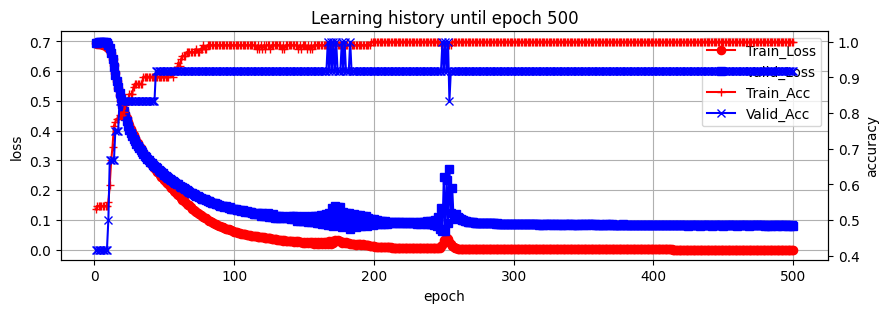

Epoch: 500 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.081 | V_Acc 0.917 | 0.987
Epoch: 499 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.082 | V_Acc 0.917 | 0.976
Epoch: 498 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.081 | V_Acc 0.917 |  0.61
Epoch: 497 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.081 | V_Acc 0.917 | 0.807
Epoch: 496 | T_Loss   0.0 | T_Acc   1.0 | V_Loss  0.08 | V_Acc 0.917 | 0.711
Epoch: 495 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.082 | V_Acc 0.917 | 0.784
Epoch: 494 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.081 | V_Acc 0.917 | 0.765
Epoch: 493 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.081 | V_Acc 0.917 | 0.989
Epoch: 492 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.081 | V_Acc 0.917 |   1.0
Epoch: 491 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.082 | V_Acc 0.917 | 0.932
Epoch: 490 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.081 | V_Acc 0.917 | 0.981
Epoch: 489 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.082 | V_Acc 0.917 | 0.764
Epoch: 488 | T_Loss   0.0 | T_Acc   1.0 | V_Loss 0.081 | V_Acc 0.917 | 0.589

In [ ]:
# Training initialization
init_model()
init_epoch()
init_log()
maximum_epoch = EPOCH
# Training iteration

while epoch_not_finished():
    start_time = time.time()

    tloss, tacc = epoch(train_loader, mode = 'train')

    end_time = time.time()
    time_taken = end_time - start_time
    record_train_log(tloss, tacc, time_taken)

    with torch.no_grad():
        vloss, vacc = epoch(val_loader, mode = 'val')
        record_valid_log(vloss, vacc)

    print_log()

print('\n Training completed!')

In [ ]:
# 정확도 검증
with torch.no_grad():
    test_loss, test_acc = epoch(test_loader, mode = 'test')
    test_acc = round(test_acc, 4)
    test_loss = round(test_loss, 4)
    print('Test Acc.: {}'.format(test_acc))
    print('Test Loss: {}'.format(test_loss))

Test Acc.: 0.8333
Test Loss: 0.9558


In [ ]:
# 영상 resize 및 추출
test_video_name = 'C_3_12_13_BU_SMB_09-01_14-47-28_CC_RGB_DF2_F2'
test_video_path = f'/content/drive/MyDrive/CCTV/TS_03.이상행동_12.절도/{test_video_name}.mp4'
cv2.destroyAllWindows()
cap = cv2.VideoCapture(test_video_path)
img_list = []

if cap.isOpened():

    while True:
        ret, img = cap.read()
        if ret:
            img = cv2.resize(img, (640, 640))
            img_list.append(img)
            # cv2_imshow(img)
            # cv2.waitKey(1)
        else:
            break

cap.release()
cv2.destroyAllWindows()

print('저장된 frame의 개수: {}'.format(len(img_list)))

저장된 frame의 개수: 180


In [ ]:
net.eval()

length = 30 # frame 상태를 표시할 길이
out_img_list = []
dataset = []
status = 'None'
pose = mp_pose.Pose(static_image_mode=True, model_complexity=1, enable_segmentation=False, min_detection_confidence=n_CONFIDENCE)
print('시퀀스 데이터 분석 중...')

xy_list_list = []
for img in tqdm(img_list):
    results = pose.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if not results.pose_landmarks: continue
    xy_list = []
    idx = 0
    draw_line_dic = {}
    for x_and_y in results.pose_landmarks.landmark:
        if idx in attention_dot:
            xy_list.append(x_and_y.x)
            xy_list.append(x_and_y.y)
            x, y = int(x_and_y.x * 640), int(x_and_y.y * 640)
            draw_line_dic[idx] = [x, y]
        idx += 1

    xy_list_list.append(xy_list)
    for line in draw_line:
        x1, y1 = draw_line_dic[line[0]][0], draw_line_dic[line[0]][1]
        x2, y2 = draw_line_dic[line[1]][0], draw_line_dic[line[1]][1]
        img = cv2.line(img, (x1, y1), (x2, y2), (0, 255, 0), 4)

    if len(xy_list_list) == length:
        dataset = []
        dataset.append({'key' : 0, 'value' : xy_list_list})
        dataset = MyDataset(dataset)
        dataset = DataLoader(dataset)
        xy_list_list = []

        for data, label in dataset:
            data = data.to(device)
            with torch.no_grad():
                result = net(data)
                _, out = torch.max(result, 1)
                if out.item() == 0:
                    status = 'Normal'
                    text_color = (255, 0, 0)
                    cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.0, text_color, 2)

                else:
                    status = 'Abnormal'
                    text_color = (0, 0, 255)
                    cv2.putText(img, status, (0, 50), cv2.FONT_HERSHEY_COMPLEX, 1.0, text_color, 2)
                    # 경고 메시지
                    cv2.putText(img, 'WARNING: Abnormal Activity Detected!', (50, img.shape[0] // 2), cv2.FONT_HERSHEY_COMPLEX, 1.0, text_color, 2)
                    cv2.rectangle(img, (0, 0), (img.shape[1], img.shape[0]), text_color, 10)

    out_img_list.append(img)

시퀀스 데이터 분석 중...


100%|██████████| 180/180 [00:20<00:00,  8.87it/s]


In [ ]:
# 테스트 원본 영상 내보내기
filename = '/content/drive/MyDrive/CCTV/Results/3DCNN_500.mp4'
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
fps = 3
frameSize = (640, 640)
isColor = True
out = cv2.VideoWriter(filename, fourcc, fps, frameSize, isColor)
for out_img in out_img_list:
    out.write(out_img)
out.release()

In [ ]:
# 모델 저장하기
PATH = '/content/drive/MyDrive/CCTV/Models/'
model_name = '3DCNN_v500.pt'
torch.save(net.state_dict(), PATH + model_name)